# Biostat 257 Homework 2

**Due Apr 29 @ 11:59PM**

In [5]:
versioninfo()

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.5.0)
  CPU: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)


In [6]:
# load libraries
using BenchmarkTools, DelimitedFiles, Images, LinearAlgebra, Random

## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).

<img src="./nnmf.png" width="500" align="center"/>

In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Lee and Seung suggest an iterative algorithm with multiplicative updates
$$
v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that will drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. In following questions, efficiency (both speed and memory) will be the most important criterion when grading this problem.

### Q1.1 Develop code

Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.

#### Answer

The above algorithm simplifies to the following expressions:
\begin{align*}
V^{(t+1)} &= V^{(t)} \odot (XW^{T,(t)} \cdot / (V^{(t)}W^{(t)}W^{(t)T}))\\
W^{(t+1)} &= W^{(t)} \odot (V^{T,(t+1)}X \cdot / (V^{T,(t+1)}V^{(t+1)}W^{(t)}))
\end{align*}

where $\odot$ is the entrywise (Hadamard) product and $\cdot /$ refers to entrywise division.

We write the following expression accordingly:

In [37]:
import LinearAlgebra: BlasReal, copytri!

function nnmf(
    X       :: Matrix{T}, 
    r       :: Integer;
    maxiter :: Integer = 1000, 
    tolfun  :: Number = 1e-4,
    V       :: Matrix{T} = rand(T, size(X, 1), r),
    W       :: Matrix{T} = rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    rr_storage = Matrix{T}(undef, r, r)
    storage_V1 = similar(V)
    storage_V2 = similar(V)
    storage_W1 = similar(W)
    storage_W2 = similar(W)
    storage_X = similar(X)
    x2norm = abs2(norm(X))
    
    X_err = similar(X)
    
    obj_old = 0
    obj = 0
#    fill!(rr_storage, 0)
    niter = maxiter
    for iter in 1:maxiter
        #TODO: how to get rid of unnecessary allocation.
        mul!(rr_storage, W, transpose(W))
        mul!(storage_V2, V, rr_storage)
        mul!(storage_V1, X, transpose(W))
        
#        V .= V .* storage_V1 ./ storage_V2
#        V .*= storage_V1
#        V ./= storage_V2
        for idx in eachindex(V)
            V[idx] *= storage_V1[idx]
            V[idx] /= storage_V2[idx]
        end
#        rr_storage .= transpose(V) * V
#        BLAS.syrk!('U', 'T', one(T), V, zero(T), rr_storage)
#        rr_storage .= Symmetric(rr_storage)
        mul!(rr_storage, transpose(V), V)
        mul!(storage_W2, rr_storage, W)
        mul!(storage_W1, transpose(V), X)
        
        obj_old = obj
        obj = x2norm
        for idx in eachindex(W)
            obj += (storage_W2[idx] - 2 * storage_W1[idx]) * W[idx]
            W[idx] *= storage_W1[idx]
            W[idx] /= storage_W2[idx]
        end
#        W .= W .* storage_W1 ./ storage_W2
        X_err .= X
        mul!(X_err, V, W, -one(T), one(T))
#        
#        obj = sum(X_err .* X_err)
        if abs(obj - obj_old) <= tolfun * (abs(obj_old) + 1)
            niter = iter
            break 
        end
    end
    
    if niter == maxiter
        @warn "maxiter reached without convergence"
    end
    # implementation
    # Output
    V, W, obj, niter
end

nnmf (generic function with 1 method)

### Q1.2 Data

Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  

Read in the [`nnmf-2429-by-361-face.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm`](https://docs.julialang.org/en/v1/stdlib/DelimitedFiles/#Delimited-Files) function, and display a couple sample images, e.g., using the [Images.jl](https://juliaimages.org/stable/) package.

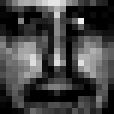

In [38]:
import DelimitedFiles: readdlm
X = readdlm("nnmf-2429-by-361-face.txt")
colorview(Gray, reshape(X[1, :], 19, 19))

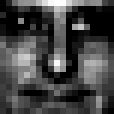

In [39]:
colorview(Gray, reshape(X[5, :], 19, 19))

### Q1.3 Correctness and efficiency

Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](https://raw.githubusercontent.com/ucla-biostat-257/2022spring/master/hw/hw2/W0.txt)) and stopping criterion
$$
\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

**Hint**: When I run the following code using my own implementation of `nnmf`
```julia
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    @time V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
end
```
the output is
```
r=10
  1.047598 seconds (20 allocations: 6.904 MiB)
obj=11730.38800985483, niter=239
r=20
  1.913147 seconds (20 allocations: 7.120 MiB)
obj=8497.222317850326, niter=394
r=30
  2.434662 seconds (20 allocations: 7.336 MiB)
obj=6621.627345486279, niter=482
r=40
  3.424469 seconds (22 allocations: 7.554 MiB)
obj=5256.663870563529, niter=581
r=50
  4.480342 seconds (23 allocations: 7.774 MiB)
obj=4430.201581697291, niter=698
```
Since my laptop is about 6-7 years old, I expect to see your run time shorter than mine. Your memory allocation should be less or equal to mine.

#### Answer

The test proceeds:

In [54]:
V0full = readdlm("V0.txt")
W0full = readdlm("W0.txt")

r = 50
V0_ref = similar(V0full[:, 1:r])
W0_ref = similar(W0full[1:r, :])

obj = 0
niter = 0
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    if (r == 50)
        V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
        V0_ref .= V
        W0_ref .= W
    else
        _, _, obj, niter = nnmf(X, r; V = V0, W = W0)
    end
    @btime nnmf($X, $r; V = $V0, W = $W0)
#    setup=(
#        copyto!($V0, V0full[:, 1:r]),
#        copyto!($W0, W0full[1:r, :])
#        )#, eval=1
    println("obj=$obj, niter=$niter")
end

r=10
  5.712 ms (15 allocations: 13.81 MiB)
obj=11728.547948792577, niter=2
r=20
  6.523 ms (15 allocations: 14.24 MiB)
obj=8495.940996631924, niter=2
r=30
  7.189 ms (15 allocations: 14.66 MiB)
obj=6620.630487325742, niter=2
r=40
  9.246 ms (15 allocations: 15.10 MiB)
obj=5255.82593154471, niter=2
r=50
  11.172 ms (16 allocations: 15.53 MiB)
obj=4429.482800163826, niter=2


### Q1.4 Non-uniqueness

Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

#### Answer

In [56]:
Random.seed!(123)
r = 50
@time V0_50, W0_50, obj, niter = nnmf(X, r)

  3.651736 seconds (33 allocations: 16.593 MiB)


([0.08381843838568455 0.022624891225047555 … 0.018196891501582824 1.506899387776284e-78; 0.08197519800025695 0.008275854498204943 … 0.008159504265946485 4.770565450901853e-101; … ; 0.01436358734928572 0.010672687353039858 … 0.02710224598401464 0.008138866006587229; 0.010527839351056799 0.003704437131533077 … 0.013702493495916226 2.702428714230538e-50], [1.126911742817193e-11 4.567094634298307e-52 … 4.484030109755306e-20 1.6959626982884854e-9; 8.890560788182038e-58 6.770132443978703e-38 … 3.904886782126298e-20 1.813774309974824e-17; … ; 1.6757316384596078e-56 5.069082658726995e-28 … 0.001260320360716669 4.227470416027437e-7; 2.80141608901472e-66 1.0913376719544036e-31 … 4.320799628289128e-17 1.134468448256185e-8], 4420.482557422309, 754)

In [57]:
norm(V0_ref - V0_50)

6.325415859002564

In [58]:
norm(W0_ref - W0_50)

292.64021039690067

The resulting numbers and iteration are approximately the same, but the objective value and $(V, W)$ are noticeably different than before: $W$ in particular deviates from the reference noticeably more than does $V$ for the different starting point, suggesting that the decomposition is not unique for a given matrix and may vary depending on the starting matrices.

### Q1.5 Fixed point

For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

#### Answer

The results follow:

In [59]:
r = 50
V = ones((size(X, 1), r))
W = ones((r, size(X, 2)))
@time V0_50, W0_50, obj, niter = nnmf(X, r; V = V, W = W)

  0.034157 seconds (28 allocations: 15.529 MiB)


([0.005474678688547896 0.005474678688547896 … 0.005474678688547896 0.005474678688547896; 0.0054413877221143984 0.0054413877221143984 … 0.0054413877221143984 0.0054413877221143984; … ; 0.005704039080945008 0.005704039080945008 … 0.005704039080945008 0.005704039080945008; 0.0056061851030169375 0.0056061851030169375 … 0.0056061851030169375 0.0056061851030169375], [0.36995177994768685 0.4606586011069409 … 0.5580793952009444 0.42552103824346577; 0.36995177994768685 0.4606586011069409 … 0.5580793952009444 0.42552103824346577; … ; 0.36995177994768685 0.4606586011069409 … 0.5580793952009444 0.42552103824346577; 0.36995177994768685 0.4606586011069409 … 0.5580793952009444 0.42552103824346577], 25297.015778490746, 4)

In [60]:
norm(V0_ref - V0_50)

4.893724708830418

In [61]:
norm(W0_ref - W0_50)

222.1989580488108

The value of $V$ is very close to that of the reference $V$, but not so for $W$. The differences are noticeably similar in order of magnitude to those of the random $V^{(0)}$ and $W^{(0)}$ above from the preceding example with random matrices.

### Q1.6 Interpret NNMF result

Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

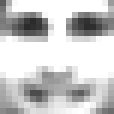

In [51]:
colorview(Gray, reshape(W[1, :], 19, 19))

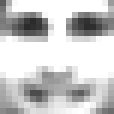

In [52]:
colorview(Gray, reshape(W[5, :], 19, 19))

The faces may be matched with those we've seen from Q1.2. However, the faces are noticeably less detailed than those in Q1.2, and are generally brighter. As we see when we multiply in $V$, the face becomes darker; $V$ may store the shading corresponding to the original image:

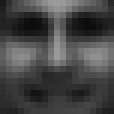

In [53]:
colorview(Gray, reshape((V * W)[1,:], 19, 19))

### Q1.7 GPU (optional)

Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in Q1.3.

In [77]:
using OpenCL

#TODO: edit for OpenCL
for r in [10, 20, 30, 40, 50]
    println("r=$r")
    V0 = V0full[:, 1:r]
    W0 = W0full[1:r, :]
    V, W, obj, niter = nnmf(X, r; V = V0, W = W0)
    @btime nnmf(X, r; V = V0, W = W0)
    println("obj=$obj, niter=$niter")
    if (r == 50)
        W
    end
end

## Q2. Estimating Kinship Matrix

Consider the numerical task of estimating an $n \times n$ kinship matrix $\Phi$ from an $n \times m$ genotype matrix $\mathbf{G}$. Here $n$ is the number of individuals and $m$ is the number of genetic markers. [Lange et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6763373/) derived a method of moment estimator of form
$$
    \widehat \Phi_{ij} = \frac{e_{ij} - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}{m - \sum_{k=1}^m [p_k^2 + (1 - p_k)^2]}, \quad 1 \le i, j \le n,
$$
where
$$
\begin{eqnarray*}
    e_{ij} &=& \frac{1}{4} \sum_{k=1}^m [g_{ik} g_{jk} + (2 - g_{ik})(2 - g_{jk})] \\
    p_k &=& \frac {1}{2n} \sum_{i=1}^n g_{ik}.
\end{eqnarray*}
$$

### Q2.1 Develop code

Write a function that takes a matrix `G` as input and outputs the method of moment estimator. 
Make your function as efficient (both speed and memory) as possible.    

In [65]:
import LinearAlgebra: BlasReal

function kinship(G::Matrix{T}) where T <: AbstractFloat
    n, m = size(G)
#    Φ = zeros(n, m)
    Φ = zeros(n, n)
#    storage_nn = zeros(n, n)
    BLAS.syrk!('U', 'N', one(T), G, one(T), Φ)
    
    sumGcol = Vector{T}(undef, n)
    one_n   = ones(T, n)
    sum!(sumGcol, G)
#    sumGcol .= mapslices(sum, G, dims = 2)
#    Φ .-= sumGcol
#    Φ .-= transpose(sumGcol)
    BLAS.syr2k!('U', 'N', -one(T), sumGcol, one_n, one(T), Φ)
#    @inbounds for i in 1:n
#        #TODO: allocation going on here???
#        sumG = sum(G[i, :])
#        @views Φ[i, :] .-= sumG
#        @views Φ[:, i] .-= sumG
#    end
    
    #TODO: don't allocate this p!!!
#    p = mapslices(sum, G, dims = 1) ./ (2 * n)
#    psum = sum(1. .- 2. * p + 2. * (p .* p))
#    pdf = sum(G) / n - 2. * sum(p .* p)
    #TODO: for loop is slower but allocates a lot less. How to speed it up?
    pdf = sum(G) / n
    sumGrow = Vector{T}(undef, m)
    sum!(sumGrow, transpose(G))
    @inbounds for j in 1:m
        pdf -= abs2(sumGrow[j]) / (2. * n * n)
    end
    
#    Φ .= Φ ./ (2. * pdf) .+ 1.
    Φ ./= (2. * pdf)
    Φ .+= 1.
    # output
    Symmetric(Φ)
end

kinship (generic function with 1 method)

### Q2.2 Correctness

First let's make sure our function yields correct answer. Run your function on a fake genotype matrix

In [66]:
# generate a fake genotype matrix with entries {0, 1, 2}
Random.seed!(257)
G = rand(0.0:2.0, 1000, 10000)
Φ = kinship(G)
Φ[1:5, 1:5]

5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777

Compare the upper left $5 \times 5$ block to what I got using my implementation

```julia
Φ[1:5, 1:5]
```

```
5×5 Matrix{Float64}:
  0.673584     -0.000762864  -0.00266412   0.00343992   0.00293959
 -0.000762864   0.665178     -0.0101691   -0.0110697    0.00223912
 -0.00266412   -0.0101691     0.665078     0.0102444    0.00253932
  0.00343992   -0.0110697     0.0102444    0.66768     -0.0083679
  0.00293959    0.00223912    0.00253932  -0.0083679    0.663777
```

### Q2.3 Efficiency

In a typical genetic data set, $n$ is at order of $10^3 \sim 10^6$ and $m$ is at order of $10^6 \sim 10^7$. Benchmark your function using the smaller data set $G$ generated in Q2.2. Efficiency (both speed and memory) will be the most important criterion when grading this question.

In [67]:
# benchmark

@btime kinship($G)
#@benchmark kinship($G)

  95.198 ms (6 allocations: 7.72 MiB)


1000×1000 Symmetric{Float64, Matrix{Float64}}:
  0.673584     -0.000762864  -0.00266412   …   0.0108448    -0.00446532
 -0.000762864   0.665178     -0.0101691        0.00994423   -0.00136326
 -0.00266412   -0.0101691     0.665078        -0.0157728    -0.00356472
  0.00343992   -0.0110697     0.0102444        0.0106447     0.00514105
  0.00293959    0.00223912    0.00253932      -0.00506571    0.00163873
 -0.00226386   -0.00626651   -0.00876817   …   0.00834317    0.00494091
  0.00684217   -0.00516578    0.00384018      -0.00486558    0.00604164
  0.00404032    0.00524111   -0.00816777      -0.00236392   -0.00696697
  0.000237799   0.00233919    0.0129462       -0.0012632    -0.00296432
  0.00564138   -0.00366479    0.0108448       -0.00736724    0.0154479
  0.00574144   -0.00606638    0.00203899   …   0.00273946   -0.00736724
 -0.00326452   -0.00856803   -0.000162467      0.00183886   -0.0089683
  0.000638064   0.00293959   -0.00306439      -0.00496565   -0.00156339
  ⋮                

**Hint**: I got `@btime` output
```
82.144 ms (3 allocations: 7.64 MiB)
```